# Imports

In [89]:
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')

import time

from numpy import random as rd
from scipy.special import gammaln
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt

# Import stopwords
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

# 1 - Collapsed Gibbs sampling for LDA

## Setup

In [2]:
def docs_to_int(corpus:str, encoding:str, nr_tokens:int, stop:list) -> (list(), Counter()):
    
    token_count = 0
    docs = list()
    docs_count = 0
    
    # Find unique words (removal of stopwords and punctuations and other stuff.)
    freqs = Counter()   
    
    with open(corpus, encoding = encoding) as f:
        
        while token_count < nr_tokens:
            
            doc = f.readline()
            docs_count += 1
            temp_doc = list()
            
            # Lemmatizion of tokens
            result = nlp(doc.lower(), disable=['tagger', 'parser', 'ner'])
            
            for token in result:
                if len(token.lemma_) > 2:
                    if token.lemma_ not in stop:
                        token_count += 1
                        freqs[token.lemma_] += 1
                        temp_doc.append(token.lemma_)
                        
            docs.append(temp_doc)

    print('Nr of tokens:' + str(token_count))
    print('Nr of docs:' + str(docs_count))
    
    # Create bag of words
    bow = []
    vocab = freqs.most_common()

    for i in range(len(vocab)):
        bow.append(vocab[i][0])

    # Get pairs of elements    
    tmp = zip(bow, range(0,len(vocab)-1))
    # Make pairs into a dictionary
    vocab = dict(tmp)
        
    # Match token to int
    docs_int = list()
    
    for doc in docs:
        docs_int.append(list([vocab.get(x) for x in doc]))
        
    return docs_int, freqs, vocab

In [3]:
#stop = list(string.punctuation)
stop = list()

for x in stopwords.words('english'):
    stop.append(x)

'''
Add a couple of more stopwords which were observed manually
'''
for x in ['-PRON-','\n','...','..',"'d'","n't"]:
    stop.append(x)
    

## Code

In [4]:
# Define variables

corpus = 'books.txt'
encoding = 'ISO-8859-1'
M = 10**5    # Corpus size

In [5]:
docs_int, freqs, vocab = docs_to_int(corpus=corpus, encoding=encoding, nr_tokens=M, stop = stop)
vocab_size = len(freqs)

Nr of tokens:100030
Nr of docs:1237


In [6]:
nan_loc = []

for d, line in enumerate(docs_int):

    for j, w in enumerate(line):
        if w == None:
            nan_loc.append((d, j))
        
nan_loc

[(1236, 99)]

In [7]:
temp_doc = []

with open(corpus, encoding = encoding) as f:
    for line_idx, line in enumerate(f):
        if line_idx == d:
            print(line)
            
            result = nlp(line.lower(), disable=['tagger', 'parser', 'ner'])
            
            for token in result:
                if len(token.lemma_) > 2:
                    if token.lemma_ not in stop:
                        
                        temp_doc.append(token.lemma_)
                             
            for idx, token in enumerate(temp_doc):
                print(idx, token)

it 's amazing how despite all the tragedies and wars , big business elitists are able to cash in on the damage while religious fundamentalists never get caught , much less held accountable . the idiots who show their hate of this book are from terrorist nations that have a knack of socializing poverty and terrorism while at the same time privatizing wealth . despite all the big talk about winning the so-called war on terrorism , the ugly truth is wars have not taught us anything . if it were n't for big business funding hitler , hitler would have had a harder time killing the jews . sadly though , even after world war ii ended , the big business elites that funded and continue to fund dictatorships like hitler , stalin , and the modern ones are not only not held accountable but often end up walking away as " heroes " . if we 're really going to win the war on terrorism and / or poverty , we 're going to have to stop supporting big business elite and stop allowing our uber-corrupt polit

In [135]:
# Quick fix - sort this out later
docs_int[nan_loc[0][0]][nan_loc[0][1]] = 0

In [9]:
freqs.most_common()[0:10]

[('book', 2795),
 ('much', 1163),
 ('read', 1097),
 ('one', 834),
 ('good', 736),
 ('like', 540),
 ('would', 524),
 ('write', 522),
 ('make', 488),
 ('story', 476)]

In [10]:
docs_int[10]

[17, 3, 0, 2121, 255, 6919, 1912, 21, 5, 116, 394, 6920, 3824, 2740]

In [11]:
vocab["astral"]

4869

## LDA Functions

In [12]:
def initialize_lda(docs_int, freqs, n_topics):
    
    n_docs = len(docs_int)
    vocab_size = len(freqs)

    # Number of times that we observe topic z in document d
    ndz = np.zeros((n_docs, n_topics))

    # Number of times that we observe word w in topic z
    nzw = np.zeros((n_topics, vocab_size))

    # Counters for documents and topics
    nd = np.zeros(n_docs)
    nz = np.zeros(n_topics)

    # Create dictionary of topics
    topics = {}

    # iterate over documents 
    for d, line in enumerate(docs_int):
        for i, w in enumerate(line):
                  
            # w = docs_int[d][i] # Numerical rep of word w in doc d

            # Initialise with a random topic
            z = np.random.randint(n_topics)
            topics[(d,i)] = z

            # Increase counters
            ndz[d, z] += 1
            nzw[z, w] += 1

            nd[d] += 1
            nz[z] += 1

    return topics, ndz, nzw, nd, nz

In [13]:
def cond_topic_prob(ndz, nzw, nz, nd, w, d, alpha, beta, n_topics, voc_size):
    """
    Conditional probability of topics. 
    """

    left = (nzw[:,w] + beta) / (nz + beta * voc_size)
    right = (ndz[d,:] + alpha) / (nd[d] + alpha * n_topics)

    p_z = left * right
    p_z /= np.sum(p_z)
    
    return p_z

In [14]:
def log_multinomial_beta(alpha, K=None):

    if K is None:
        # alpha is assumed to be a vector
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        # alpha is assumed to be a scalar
        return K * gammaln(alpha) - gammaln(K*alpha)


In [15]:
def loglikelihood(n_topics, voc_size, alpha, beta, nzw, ndz):
    likelihood = 0
    
    n_docs = ndz.shape[0]
    
    for z in range(n_topics):
        likelihood += log_multinomial_beta(nzw[z,:] + beta)
        likelihood -= log_multinomial_beta(beta, voc_size)
        
    for d in range(n_docs):
        likelihood += log_multinomial_beta(ndz[d,:] + alpha)
        likelihood -= log_multinomial_beta(alpha, n_topics)
        
    return likelihood

In [20]:
def LDA_Gibbs_Sampler(docs_int, voc_size, n_topics, max_iterations, alpha, beta, freqs):

    start_time = time.time()
    log_vec = []
    topics, ndz, nzw, nd, nz = initialize_lda(docs_int, freqs, n_topics)

    for i in range(max_iterations):
        for d, line in enumerate(docs_int):
             for j, w in enumerate(line):
                
                z = topics[(d, j)]
                ndz[d, z] -= 1
                nzw[z, w] -= 1
                nd[d] -= 1
                nz[z] -= 1
            
                # Compute probabilities, and choose a new topic z
                p_z = cond_topic_prob(ndz, nzw, nz, nd, w, d, alpha, beta, n_topics, vocab_size)
                z = np.random.multinomial(1, p_z).argmax() # maybe don't use argmax, use it as a probability
                
                ndz[d,z] += 1
                nzw[z,w] += 1
                nd[d] += 1
                nz[z] += 1
                topics[(d, j)] = z    
        
        if i % 10 == 0:
            print("Iteration", i)
            
            # Calculate log likelihood
            log_l = loglikelihood(n_topics, voc_size, alpha, beta, nzw, ndz)
            log_vec.append(log_l)
            print("Likelihood", log_l)

    elapsed_time = time.time() - start_time
    print("Elapsed time: ", elapsed_time)
    
    return nzw, log_vec

In [17]:
def show_words_by_topic(word_topic_prob, vocabulary, typical_len):
    
    n_topics = word_topic_prob.shape[0]
    typical_words = []

    for i in range(n_topics):
        arr = word_topic_prob[i,:]
        typical_ints = arr.argsort()[-typical_len-2:-2][::-1]   # there's some funny business with the last word in vocab
        #print(typical_ints)

        for search_int in typical_ints:
            if search_int in [0, -1]:
                typical_words.append("")
            else:
                for k, v in vocabulary.items(): 
                    if v == search_int:
                        typical_words.append(k)
                        break

    # Print the most common words in each topic
    typical_words = np.reshape(typical_words, [n_topics, -1])
    print(typical_words)

## Code

In [121]:
it = 400      # Nr of iterations

### 10 Topics, $\alpha = \beta = 0.1$

Iteration 0
Likelihood -1032404.0797602335
Iteration 10
Likelihood -923691.7263883833
Iteration 20
Likelihood -903896.2155518925
Iteration 30
Likelihood -893974.7724219951
Iteration 40
Likelihood -889392.2656591529
Iteration 50
Likelihood -885255.2946135086
Iteration 60
Likelihood -883507.2003660903
Iteration 70
Likelihood -880579.0395155222
Iteration 80
Likelihood -878410.5853517882
Iteration 90
Likelihood -877243.6137591964
Iteration 100
Likelihood -874813.2720250909
Iteration 110
Likelihood -872605.8079628327
Iteration 120
Likelihood -870815.219891466
Iteration 130
Likelihood -869247.64045504
Iteration 140
Likelihood -868682.240191625
Iteration 150
Likelihood -868299.0636592628
Iteration 160
Likelihood -867516.9617323613
Iteration 170
Likelihood -865926.6826918499
Iteration 180
Likelihood -864948.0154762262
Iteration 190
Likelihood -863244.3425945294
Iteration 200
Likelihood -861091.3095659362
Iteration 210
Likelihood -859246.315892085
Iteration 220
Likelihood -857986.4077502127
Ite

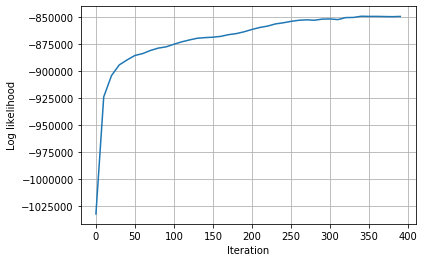

In [122]:
K = 10
alpha = 0.1
beta = alpha

word_topic_prob_01_10, log_lik_01_10 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [127]:
show_words_by_topic(word_topic_prob_01_10, vocab, 10)

[['story' 'woman' 'reader' 'man' 'jason' 'plot' 'human' 'series' 'murder'
  'sex']
 ['mother' 'family' 'old' 'dog' 'young' 'father' 'life' 'man' 'year'
  'school']
 ['history' 'sam' 'news' 'political' 'government' 'country' 'account'
  'america' 'state' 'military']
 ['translation' 'cat' 'language' 'funny' 'use' 'word' 'introduction'
  'name' 'dictionary' 'english']
 ['good' 'use' 'work' 'many' 'think' 'write' 'student' 'example' 'make'
  'understand']
 ['food' 'eat' 'include' 'plant' 'cook' 'find' 'look' 'guide' 'diet'
  'garden']
 ['norris' 'play' 'money' 'school' 'team' 'real' 'mcginnis' 'mcdonald'
  'estate' 'rich']
 ['music' 'mean' 'art' 'artist' 'contemporary' 'student' 'journey'
  'pattern' 'original' 'cell']
 ['smith' 'church' 'prospero' 'modern' 'horse' 'machine' 'science'
  'spiritual' 'ancient' 'man']
 ['much' 'one' 'like' 'good' 'would' 'time' 'get' 'write' 'make' 'find']]


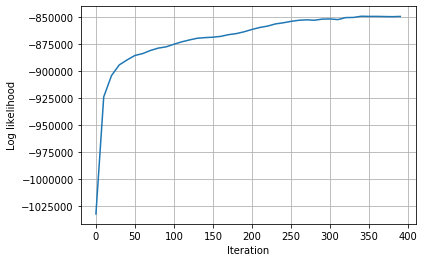

In [128]:
plt.plot(range(0, it, 10), log_lik_01_10)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

### 50 Topics, $\alpha = \beta = 0.1$

Iteration 0
Likelihood -1182689.14752616
Iteration 10
Likelihood -994990.689248799
Iteration 20
Likelihood -951603.0399049424
Iteration 30
Likelihood -927141.0115349921
Iteration 40
Likelihood -915381.3917071999
Iteration 50
Likelihood -906532.8434499218
Iteration 60
Likelihood -899585.6598606339
Iteration 70
Likelihood -895585.097808803
Iteration 80
Likelihood -893333.3523915298
Iteration 90
Likelihood -891457.5222107462
Iteration 100
Likelihood -889679.6335538579
Iteration 110
Likelihood -890258.88566321
Iteration 120
Likelihood -887487.047747247
Iteration 130
Likelihood -887162.7629106794
Iteration 140
Likelihood -887365.1008180174
Iteration 150
Likelihood -886587.0906295455
Iteration 160
Likelihood -886041.7132673647
Iteration 170
Likelihood -885989.9339772859
Iteration 180
Likelihood -885550.655989997
Iteration 190
Likelihood -886269.3361995897
Iteration 200
Likelihood -884740.4917677735
Iteration 210
Likelihood -884604.607452892
Iteration 220
Likelihood -885379.9187646321
Iterati

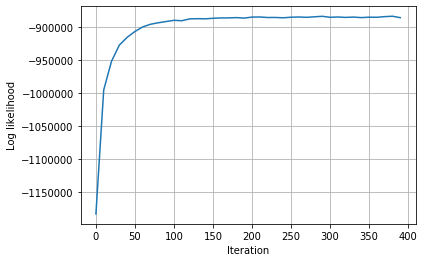

In [123]:
K = 50
alpha = 0.1
beta = alpha

word_topic_prob_01_50, log_lik_01_50 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [129]:
show_words_by_topic(word_topic_prob_01_50, vocab, 10)

[['religious' 'evidence' 'worship' 'dirk' 'claim' 'warn' 'computer'
  'morton' 'probability' 'technology']
 ['mcginnis' 'mcdonald' 'nature' 'nightjohn' 'another' 'man' 'ethic'
  'theory' 'slave' 'though']
 ['much' 'story' 'one' 'good' 'like' 'character' 'love' 'get' 'would'
  'time']
 ['medium' 'team' 'reporter' 'aid' 'numb' 'wilson' 'steve' 'liberal'
  'york' 'disaster']
 ['corp' 'hmong' 'culture' 'river' 'pakistan' 'ebay' 'critic' 'meaker'
  'levee' 'katrina']
 ['community' 'historical' 'bible' 'pray' 'christian' 'vampire' 'pope'
  'release' 'hal' 'prophecy']
 ['god' 'whitman' 'coast' 'captain' 'dick' 'literary' 'ash' 'poem' 'bud'
  'weaver']
 ['mike' 'howard' 'conan' 'dozen' 'plague' 'horton' 'wyoh' 'anna'
  'outstanding' 'colony']
 ['card' 'invest' 'rich' 'financial' 'success' 'oil' 'poor' 'gay'
  'millionaire' 'message']
 ['testament' 'cameron' 'alpha' 'mann' 'dictionary' 'wolf' 'yapko'
  'participant' 'power' 'foster']
 ['map' 'space' 'wine' 'security' 'historian' 'pack' 'trip' '

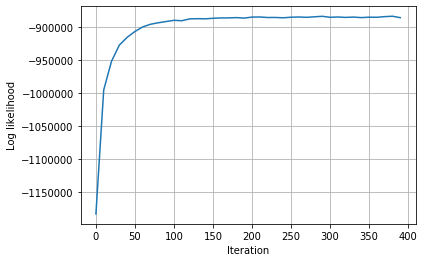

In [130]:
plt.plot(range(0, it, 10), log_lik_01_50)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

### 10 Topics, $\alpha = \beta = 0.01$

Iteration 0
Likelihood -1068852.1747088158
Iteration 10
Likelihood -935907.679862206
Iteration 20
Likelihood -920018.5906413506
Iteration 30
Likelihood -912786.378300575
Iteration 40
Likelihood -907738.5022175435
Iteration 50
Likelihood -903531.5800999552
Iteration 60
Likelihood -900719.083867321
Iteration 70
Likelihood -898076.824728633
Iteration 80
Likelihood -896442.2705336084
Iteration 90
Likelihood -894831.5177883953
Iteration 100
Likelihood -893553.9327822812
Iteration 110
Likelihood -892101.2898480312
Iteration 120
Likelihood -890453.920928218
Iteration 130
Likelihood -889432.3339442007
Iteration 140
Likelihood -887899.1890265131
Iteration 150
Likelihood -886369.8357966606
Iteration 160
Likelihood -886076.8808425341
Iteration 170
Likelihood -885060.9975182969
Iteration 180
Likelihood -883802.7052039274
Iteration 190
Likelihood -883258.382819362
Iteration 200
Likelihood -882560.2420944609
Iteration 210
Likelihood -882017.2330215132
Iteration 220
Likelihood -881775.2706920732
Iter

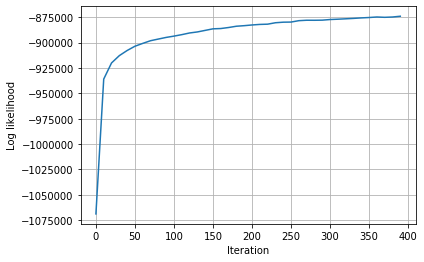

In [124]:
K = 10
alpha = 0.01
beta = alpha

word_topic_prob_001_10, log_lik_001_10 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [131]:
show_words_by_topic(word_topic_prob_001_10, vocab, 10)

[['like' 'say' 'author' 'one' 'get' 'much' 'even' 'know' 'see' 'make']
 ['sam' 'family' 'novel' 'death' 'take' 'old' 'year' 'love' 'character'
  'live']
 ['character' 'work' 'love' 'one' 'series' 'world' 'plot' 'fiction'
  'tale' 'mystery']
 ['real' 'include' 'food' 'day' 'erica' 'year' 'three' 'mention' 'eat'
  'cook']
 ['world' 'much' '' 'great' 'live' 'self' 'many' 'people' 'experience'
  'work']
 ['man' 'love' 'god' 'play' 'one' 'make' 'also' 'doe' 'become' 'another']
 ['good' 'use' 'read' 'make' 'great' 'work' 'would' 'take' 'think' 'also']
 ['write' 'much' 'read' 'time' 'many' 'little' 'reader' 'find' 'good'
  'work']
 ['much' 'one' 'good' 'would' 'like' 'get' 'find' 'time' 'well' 'write']
 ['human' 'american' 'world' 'much' 'state' 'account' 'interest' 'show'
  'power' 'understand']]


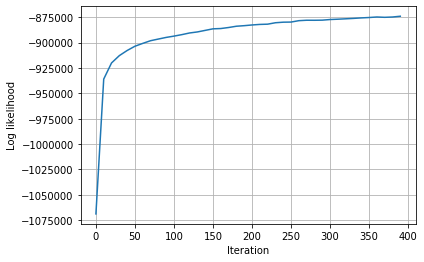

In [132]:
plt.plot(range(0, it, 10), log_lik_001_10)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

### 50 Topics, $\alpha = \beta = 0.01$

Iteration 0
Likelihood -1190341.111029679
Iteration 10
Likelihood -950401.2821342411
Iteration 20
Likelihood -927367.9264104791
Iteration 30
Likelihood -917806.0971874195
Iteration 40
Likelihood -911120.8866987126
Iteration 50
Likelihood -906899.6797617208
Iteration 60
Likelihood -903555.7031819011
Iteration 70
Likelihood -900429.6007665116
Iteration 80
Likelihood -897869.6554888989
Iteration 90
Likelihood -894549.8423284735
Iteration 100
Likelihood -893586.4005781844
Iteration 110
Likelihood -892401.8520005256
Iteration 120
Likelihood -891057.567225403
Iteration 130
Likelihood -889910.6543435233
Iteration 140
Likelihood -888308.3497488376
Iteration 150
Likelihood -887279.2544167578
Iteration 160
Likelihood -885880.0628348708
Iteration 170
Likelihood -884349.6007468438
Iteration 180
Likelihood -883633.8959385153
Iteration 190
Likelihood -882571.7150303713
Iteration 200
Likelihood -882349.1190868967
Iteration 210
Likelihood -881592.7386724561
Iteration 220
Likelihood -880876.0226334232


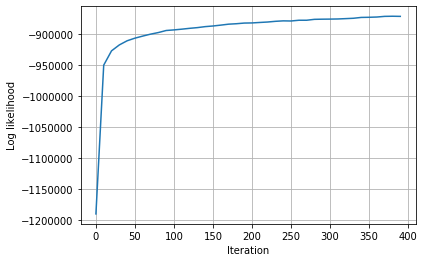

In [125]:
K = 50
alpha = 0.01
beta = alpha

word_topic_prob_001_50, log_lik_001_50 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [133]:
show_words_by_topic(word_topic_prob_001_50, vocab, 10)

[['much' 'good' 'like' 'write' 'give' 'get' 'make' 'great' 'love' 'one']
 ['need' 'figure' 'oil' 'place' 'fan' 'must' 'every' 'god' '' 'change']
 ['faith' 'transformation' 'never' 'community' 'social' 'dimension'
  'brilliant' 'europe' 'snake' '....']
 ['doe' 'take' 'hundred' 'note' 'set' 'greek' 'anne' 'upon' 'british'
  'classic']
 ['military' 'political' 'much' 'soviet' 'show' 'america' 'bush'
  'vietnam' 'world' 'country']
 ['school' 'young' 'love' 'see' 'year' 'old' 'adult' 'kid' 'one' 'parent']
 ['use' 'plant' 'another' 'common' 'real' 'illustration' 'color' 'plan'
  'pattern' 'provide']
 ['experience' 'personal' 'offer' 'spiritual' 'family' 'use' 'grow'
  'dream' 'land' 'race']
 ['read' 'know' 'one' 'time' 'today' 'take' 'make' 'believe' 'life'
  'want']
 ['reader' 'interest' 'piece' 'culture' 'one' 'west' 'use' 'part'
  'english' 'language']
 ['translation' 'original' 'rise' 'vampire' 'master' 'full' 'name'
  'chinese' 'heaven' 'word']
 ['collection' 'gibbon' 'make' 'without' '

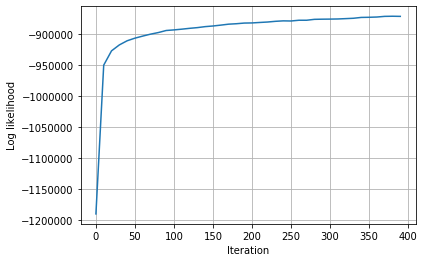

In [134]:
plt.plot(range(0, it, 10), log_lik_001_50)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

### Save results as csv

In [126]:
np.savetxt("nzw_01_10.csv", word_topic_prob_01_10, delimiter=",")
np.savetxt("nzw_01_50.csv", word_topic_prob_01_50, delimiter=",")
np.savetxt("nzw_001_10.csv", word_topic_prob_001_10, delimiter=",")
np.savetxt("nzw_001_50.csv", word_topic_prob_001_50, delimiter=",")

# 2 - Bigram LDA

In [207]:
def count_bigram_topics(topics, docs_int):
    
    topic_counter = defaultdict(Counter)
    
    for d, line in enumerate(docs_int):
        
        for i, (w_1, w_2) in enumerate(zip(line, line[1:])):
            
            # Retrieve the topic of the second word
            z = topics[(d, i+1)]
            
            topic_counter[(w_1, w_2)][z] += 1
        
    return topic_counter

In [211]:
def cond_prob_bigram(w_prev, w, d, ndz, nzw, alpha, beta, bigram_topics):
    
    n_topics = ndz.shape[1]
    voc_size = nzw.shape[1]
    p_z = np.zeros(n_topics)

    for k in range(n_topics):
        left = ( bigram_topics[(w_prev, w)][k] + beta )/( nzw[k, w_prev + 1] + beta*voc_size)
        right = ( ndz[d,k] + alpha )

        p_z[k] = left*right

    p_z /= sum(p_z)
    return p_z

In [242]:
def run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics):

    start_time = time.time()
    
    topics, ndz, nzw, nd, nz = initialize_lda(docs_int, freqs, n_topics)
    bigram_topics = count_bigram_topics(topics, docs_int)

    for i in range(max_iterations):
        for d, line in enumerate(docs_int):
            for j, w in enumerate(line):
                
                # can't use the first word in a document - there's no previous word for the bigram
                if j > 0:

                    z = topics[(d, j)]
                    ndz[d, z] -= 1
                    nzw[z, w] -= 1
                    nd[d] -= 1
                    nz[z] -= 1

                    # preceding word in the bigram   
                    w_prev = line[j-1]

                    bigram_topics[(w_prev, w)][z] -= 1
                    p_z = cond_prob_bigram(w_prev, w, d, ndz, nzw, alpha, beta, bigram_topics)
                    z = rd.multinomial(1, p_z).argmax()

                    ndz[d,z] += 1
                    nzw[z,w] += 1
                    nd[d] += 1
                    nz[z] += 1
                    topics[(d, j)] = z

                    bigram_topics[(w_prev, w)][z] += 1

        if i % 10 == 0: 
            print("Iteration", i)

    elapsed_time = time.time() - start_time
    print("Elapsed time: ", elapsed_time)

    return nzw

In [239]:
bigram_topics = count_bigram_topics(topics, docs_int)
bigram_topics[(0, 1)]

Counter({4: 4, 0: 3, 7: 2, 2: 2, 9: 5, 8: 6, 5: 2, 3: 4, 1: 3, 6: 2})

### 5 Topics, $\alpha$ = $\beta$ = 0.1

In [243]:
alpha = 0.1
beta = alpha
n_topics = 5
max_iterations = 200

bigram_prob_01_5 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1420.5678217411041


In [244]:
show_words_by_topic(bigram_prob_01_5, vocab, 10)

[['good' 'read' 'much' 'find' 'novel' 'really' 'think' 'love' 'interest'
  'great']
 ['read' 'one' 'good' 'like' 'write' 'would' 'make' 'time' 'story' 'find']
 ['good' 'much' 'one' 'great' 'story' 'like' 'love' 'get' 'interest'
  'woman']
 ['read' 'find' 'one' 'think' 'great' 'work' 'end' 'even' 'really' 'many']
 ['great' 'find' 'one' 'much' 'love' 'think' 'see' 'good' 'make' 'start']]


### 10 Topics, $\alpha$ = $\beta$ = 0.1

In [245]:
alpha = 0.1
beta = alpha
n_topics = 10

bigram_prob_01_10 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1553.2429900169373


In [246]:
show_words_by_topic(bigram_prob_01_10, vocab, 10)

[['good' 'story' 'love' 'great' 'long' 'woman' 'wonderful' 'much' 'start'
  'find']
 ['make' 'life' 'great' 'write' 'novel' 'love' 'right' 'global' 'story'
  'time']
 ['read' 'story' 'much' 'good' 'think' 'find' 'would' 'great' 'get'
  'year']
 ['read' 'one' 'good' 'like' 'would' 'write' 'make' 'time' 'story' 'find']
 ['one' 'great' 'work' 'get' 'good' 'write' 'make' 'become' 'like'
  'really']
 ['good' 'much' 'many' 'read' 'use' 'must' 'story' 'find' 'even' 'enjoy']
 ['one' 'little' 'really' 'would' 'work' 'think' 'great' 'excellent'
  'live' 'hear']
 ['much' 'read' 'great' 'say' 'author' 'many' 'find' 'even' 'make' 'one']
 ['read' 'good' 'find' 'great' 'work' 'use' 'write' 'make' 'story' 'long']
 ['read' 'good' 'like' 'one' 'write' 'two' 'character' 'keep' 'think'
  'well']]


### 5 Topics, $\alpha$ = $\beta$ = 0.01

In [247]:
alpha = 0.01
beta = alpha
n_topics = 5

bigram_prob_001_5 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1364.184497833252


In [248]:
show_words_by_topic(bigram_prob_001_5, vocab, 10)

[['one' 'good' 'read' 'find' 'story' 'love' 'work' 'great' 'would' 'get']
 ['read' 'one' 'make' 'would' 'time' 'story' 'good' 'find' 'get' 'want']
 ['one' 'read' 'good' 'like' 'great' 'find' 'work' 'would' 'people'
  'write']
 ['much' 'one' 'good' 'like' 'write' 'would' 'make' 'time' 'story' 'get']
 ['one' 'good' 'read' 'doe' 'think' 'time' 'write' 'like' 'use' 'find']]


### 10 Topics, $\alpha$ = $\beta$ = 0.01

In [ ]:
alpha = 0.01
beta = alpha
n_topics = 10

bigram_prob_001_10 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190


In [ ]:
show_words_by_topic(bigram_prob_001_10, vocab, 10)